# Lecture 15 : More OpenMP Examples

## Clone the materials repo to access datafiles.

In [1]:
!git clone https://code.vt.edu/jasonwil/cmda3634_materials.git

Cloning into 'cmda3634_materials'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 195 (delta 69), reused 37 (delta 16), pack-reused 39 (from 1)
Receiving objects: 100% (195/195), 28.41 MiB | 5.04 MiB/s, done.
Resolving deltas: 100% (69/69), done.
Updating files: 100% (68/68), done.


In [2]:
!cp cmda3634_materials/L15/* .

# Part 1 : Strong Scaling Studies for OpenMP Extreme

## *Definitions:*
### **Speedup** = $\frac{\text{seconds for 1 core}}{\text{seconds for k cores}}$
### A **Strong Scaling Study** shows how the speedup varies with the number of cores for a **fixed problem size**.

## In this part we will use strong scaling studies to compare speedup with and without the OpenMP **collapse** clause.

## Here is the extreme code from lecture 14 with a few additional compile options added (loop collapse and timing).


In [ ]:
%%writefile omp_extreme.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>
#include "vec.h"

typedef struct {
    double max_dist_sq;
    int extreme_1, extreme_2;
} extreme_info;

extreme_info extreme_pair (double* data, int len, int dim) {
    extreme_info info = { 0, -1, -1 };
#pragma omp parallel default(none) shared(len,dim,data,info)
    {
        extreme_info thread_info;
#ifdef COLLAPSE
#pragma omp for collapse(2)
#else
#pragma omp for
#endif
        for (int i=0;i<len-1;i++) {
            for (int j=i+1;j<len;j++) {
                double dist_sq = vec_dist_sq(data+i*dim,data+j*dim,dim);
                if (dist_sq > thread_info.max_dist_sq) {
                    thread_info.max_dist_sq = dist_sq;
                    thread_info.extreme_1 = i;
                    thread_info.extreme_2 = j;
                }
            }
        }
#pragma omp critical
        {
            if (thread_info.max_dist_sq > info.max_dist_sq) {
                info = thread_info;
            }
        }
    }
    return info;
}

int main (int argc, char** argv) {

    // get num_threads from the command line
    if (argc < 2) {
        printf ("Command usage : %s num_threads\n",argv[0]);
        return 1;
    }
    int num_threads = atoi(argv[1]);
    omp_set_num_threads(num_threads);

    // read dataset with len points in R^dim
    int len, dim;
    if (scanf("%d %d",&len,&dim) != 2) {
        printf ("error reading the length and dimension of the dataset\n");
        return 1;
    }
    // allocate the (len x dim) data matrix on the heap using malloc
    double* data = (double*)malloc(len*dim*sizeof(double));
    if (data == NULL) {
        printf ("malloc failed to allocate data matrix\n");
        return 1;
    }
    vec_read_dataset (data,len,dim);

    // start the timer
    double start_time, end_time;
    start_time = omp_get_wtime();

    // find the extreme pair
    extreme_info info;
    info = extreme_pair(data,len,dim);

    // stop the timer
    end_time = omp_get_wtime();

    // print the results
#ifdef TIMING
    printf ("(%d,%.4f),",num_threads,end_time-start_time);
#else
    printf ("num_threads = %d, ",num_threads);
    printf ("elapsed time = %.4f seconds\n",end_time-start_time);
    printf ("Extreme Distance = %.2f\n",sqrt(info.max_dist_sq));
    printf ("Extreme Pair = %d %d\n",info.extreme_1,info.extreme_2);
#endif

    // free the data matrix
    free (data);
}

Writing omp_extreme.c


## Here is a shell script that generates timing output without the collapse clause.

In [ ]:
%%writefile study.sh
# compile with TIMING flag
gcc -DTIMING -o omp_extreme omp_extreme.c vec.c -lm -fopenmp

# run with 1, 2, 4, 8, 16, and 32 threads
cat $1 | ./omp_extreme 1
cat $1 | ./omp_extreme 2
cat $1 | ./omp_extreme 4
cat $1 | ./omp_extreme 8
cat $1 | ./omp_extreme 16
cat $1 | ./omp_extreme 32

# output a newline
echo

## Running this script on matrix generates the following output.
    $ bash study.sh mnist2000.txt
    (1,4.2885),(2,3.2135),(4,1.9244),(8,1.0611),(16,0.5587),(32,0.2918),

## Here is some Python code for plotting the ideal speedup versus the actual speedup for different thread counts.

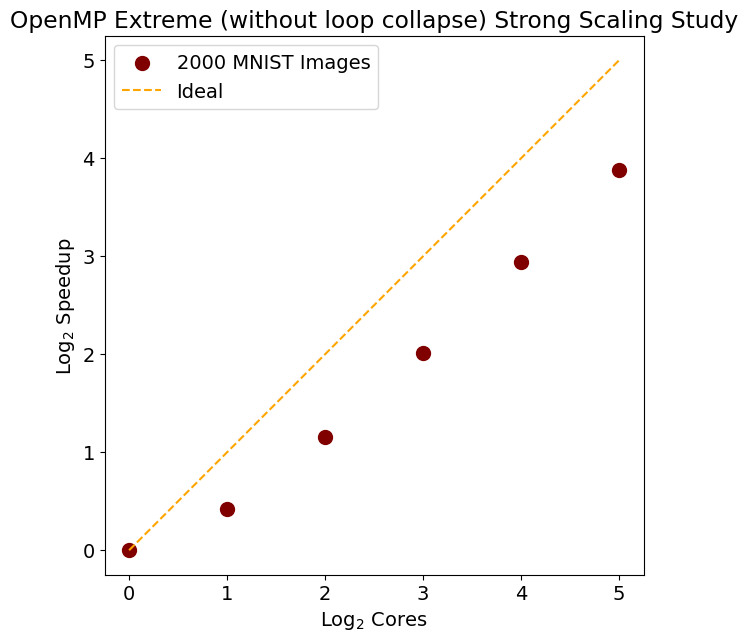

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
A = np.array ( ( (1,4.2885),(2,3.2135),(4,1.9244),(8,1.0611),(16,0.5587),(32,0.2918) ) )
slow_time = A[0,1]
A[:,1] = slow_time/A[:,1]
plt.rcParams['figure.figsize'] = (7, 7)
plt.rcParams.update({'font.size': 14})
plt.gca().set_aspect('equal')
plt.scatter (np.log2(A[:,0]),np.log2(A[:,1]),color='maroon',s=100,label='2000 MNIST Images')
plt.plot ([0,5],[0,5],'--',color='orange',label='Ideal')
plt.title ('OpenMP Extreme (without loop collapse) Strong Scaling Study')
plt.xlabel ('Log$_2$ Cores')
plt.ylabel ('Log$_2$ Speedup')
plt.legend();

## Here is a shell script that generates timing output without the collapse clause.

In [ ]:
%%writefile study2.sh
# compile with TIMING and COLLAPSE flags
gcc -DTIMING -DCOLLAPSE -o omp_extreme omp_extreme.c vec.c -lm -fopenmp

# run with 1, 2, 4, 8, 16, and 32 threads
cat $1 | ./omp_extreme 1
cat $1 | ./omp_extreme 2
cat $1 | ./omp_extreme 4
cat $1 | ./omp_extreme 8
cat $1 | ./omp_extreme 16
cat $1 | ./omp_extreme 32

# output a newline
echo

## Running this script on matrix generates the following output.
    $ bash study2.sh mnist2000.txt
    (1,4.2854),(2,2.1488),(4,1.1428),(8,0.5880),(16,0.3009),(32,0.1602),

## Here is some Python code for plotting the ideal speedup versus the actual speedup for different thread counts.

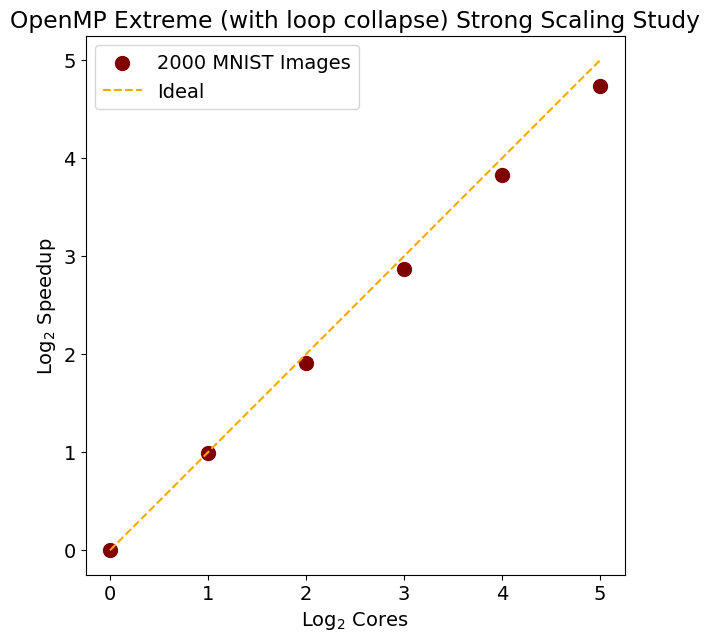

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
A = np.array ( ( (1,4.2854),(2,2.1488),(4,1.1428),(8,0.5880),(16,0.3009),(32,0.1602) ) )
slow_time = A[0,1]
A[:,1] = slow_time/A[:,1]
plt.rcParams['figure.figsize'] = (7, 7)
plt.rcParams.update({'font.size': 14})
plt.gca().set_aspect('equal')
plt.scatter (np.log2(A[:,0]),np.log2(A[:,1]),color='maroon',s=100,label='2000 MNIST Images')
plt.plot ([0,5],[0,5],'--',color='orange',label='Ideal')
plt.title ('OpenMP Extreme (with loop collapse) Strong Scaling Study')
plt.xlabel ('Log$_2$ Cores')
plt.ylabel ('Log$_2$ Speedup')
plt.legend();

# Part 2 : OpenMP Standard Deviation

## The standard deviation of the numbers $1 ... N$ is given by
$$\sigma = \sqrt{\frac{N^2-1}{12}}$$

## A sequential code to compute the standard deviation of the numbers $1 ... N$ is given below.  

In [ ]:
%%writefile std_dev.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

int main (int argc, char** argv) {

    // get N from the command line
    if (argc < 2) {
        printf ("Command usage : %s N\n",argv[0]);
        return 1;
    }
    long long N = atoll(argv[1]);

    // initialize sums
    double sum_diff_sq = 0;
    long long sum = 0;

    // compute the mean
    for (long long i=1;i<=N;i++) {
        sum += i;
    }
    double mean = 1.0*sum/N;

    // compute the sum of differences squared
    for (long long i=1;i<=N;i++) {
        sum_diff_sq += (i-mean)*(i-mean);
    }

    // compute the standard deviation
    double std_dev = sqrt(sum_diff_sq/N);

    // print the results
    printf ("computed std dev is %.1lf",std_dev);
    printf (", sqrt((N^2-1)/12) is %.1lf\n",sqrt((N*N-1)/12.0));

}

Writing std_dev.c


In [ ]:
!gcc -o std_dev std_dev.c -lm

In [ ]:
!time ./std_dev 1000000000

computed std dev is 288675134.6, sqrt((N^2-1)/12) is 288675134.6

real	0m6.876s
user	0m6.608s
sys	0m0.006s


## In our first OpenMP version we add reading num_threads and timing code.

In [ ]:
%%writefile omp_std_dev_v1.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>

int main (int argc, char** argv) {

    // get N and num_threads from the command line
    if (argc < 3) {
        printf ("Command usage : %s N num_threads\n",argv[0]);
        return 1;
    }
    long long N = atoll(argv[1]);
    int num_threads = atoi(argv[2]);
    omp_set_num_threads(num_threads);

    // start the timer
    double start_time, end_time;
    start_time = omp_get_wtime();

    // initialize sums
    double sum_diff_sq = 0;
    long long sum = 0;

    // compute the mean
    for (long long i=1;i<=N;i++) {
        sum += i;
    }
    double mean = 1.0*sum/N;

    // compute the sum of differences squared
    for (long long i=1;i<=N;i++) {
        sum_diff_sq += (i-mean)*(i-mean);
    }

    // compute the standard deviation
    double std_dev = sqrt(sum_diff_sq/N);

    // stop the timer
    end_time = omp_get_wtime();

    // print the results
    printf ("num_threads = %d, ",num_threads);
    printf ("elapsed time = %.4f seconds\n",end_time-start_time);
    printf ("computed std dev is %.1lf",std_dev);
    printf (", sqrt((N^2-1)/12) is %.1lf\n",sqrt((N*N-1)/12.0));

}

Overwriting omp_std_dev_v1.c


In [ ]:
!gcc -o omp_std_dev_v1 omp_std_dev_v1.c -lm -fopenmp

In [ ]:
!./omp_std_dev_v1 1000000 1

num_threads = 1, elapsed time = 0.0066 seconds
computed std dev is 288675.1, sqrt((N^2-1)/12) is 288675.1


## For our second version, we add a parallel region to run the two for loops in parallel.  

## Note that we use thread versions of the sums for efficiency and use the atomic operations outside the for loops for thread safety.

In [ ]:
%%writefile omp_std_dev_v2.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>

int main (int argc, char** argv) {

    // get N and num_threads from the command line
    if (argc < 3) {
        printf ("Command usage : %s N num_threads\n",argv[0]);
        return 1;
    }
    long long N = atoll(argv[1]);
    int num_threads = atoi(argv[2]);
    omp_set_num_threads(num_threads);

    // start the timer
    double start_time, end_time;
    start_time = omp_get_wtime();

    // initialize sums
    double sum_diff_sq = 0;
    long long sum = 0;

#pragma omp parallel
    {
	// compute the sum
	long long thread_sum = 0;
#pragma omp for
	for (long long i=1;i<=N;i++) {
	    thread_sum += i;
	}
#pragma omp atomic
	sum += thread_sum;

	// compute the mean
	double mean = 1.0*sum/N;

	// compute the sum of differences squared
	double thread_sum_diff_sq = 0;
#pragma omp for
	for (long long i=1;i<=N;i++) {
	    thread_sum_diff_sq += (i-mean)*(i-mean);
	}
#pragma omp atomic
	sum_diff_sq += thread_sum_diff_sq;
    }

    // compute the standard deviation
    double std_dev = sqrt(sum_diff_sq/N);

    // stop the timer
    end_time = omp_get_wtime();

    // print the results
    printf ("num_threads = %d, ",num_threads);
    printf ("elapsed time = %.4f seconds\n",end_time-start_time);
    printf ("computed std dev is %.1lf",std_dev);
    printf (", sqrt((N^2-1)/12) is %.1lf\n",sqrt((N*N-1)/12.0));

}

Writing omp_std_dev_v2.c


In [ ]:
!gcc -o omp_std_dev_v2 omp_std_dev_v2.c -lm -fopenmp

In [ ]:
!./omp_std_dev_v2 10000000 2

num_threads = 2, elapsed time = 0.0865 seconds
computed std dev is 2447362.6, sqrt((N^2-1)/12) is 2886751.3


## Note that version 2 computes the wrong answer!
## What do you think the problem is with the code?
## Answer:
## Here is version 3 which fixes the issue.

In [ ]:
%%writefile omp_std_dev_v3.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>

int main (int argc, char** argv) {

    // get N and num_threads from the command line
    if (argc < 3) {
        printf ("Command usage : %s N num_threads\n",argv[0]);
        return 1;
    }
    long long N = atoll(argv[1]);
    int num_threads = atoi(argv[2]);
    omp_set_num_threads(num_threads);

    // start the timer
    double start_time, end_time;
    start_time = omp_get_wtime();

    // initialize sums
    double sum_diff_sq = 0;
    long long sum = 0;

#pragma omp parallel
    {
	// compute the sum
	long long thread_sum = 0;
#pragma omp for
	for (long long i=1;i<=N;i++) {
	    thread_sum += i;
	}
#pragma omp atomic
	sum += thread_sum;

#pragma omp barrier
	// compute the mean
	double mean = 1.0*sum/N;

	// compute the sum of differences squared
	double thread_sum_diff_sq = 0;
#pragma omp for
	for (long long i=1;i<=N;i++) {
	    thread_sum_diff_sq += (i-mean)*(i-mean);
	}
#pragma omp atomic
	sum_diff_sq += thread_sum_diff_sq;
    }

    // compute the standard deviation
    double std_dev = sqrt(sum_diff_sq/N);

    // stop the timer
    end_time = omp_get_wtime();

    // print the results
    printf ("num_threads = %d, ",num_threads);
    printf ("elapsed time = %.4f seconds\n",end_time-start_time);
    printf ("computed std dev is %.1lf",std_dev);
    printf (", sqrt((N^2-1)/12) is %.1lf\n",sqrt((N*N-1)/12.0));

}

Writing omp_std_dev_v3.c


In [ ]:
!gcc -o omp_std_dev_v3 omp_std_dev_v3.c -lm -fopenmp

In [ ]:
!./omp_std_dev_v3 10000000 2

num_threads = 2, elapsed time = 0.0665 seconds
computed std dev is 2886751.3, sqrt((N^2-1)/12) is 2886751.3


## The issue with version 2 is that a thread could compute the mean using
    // compute the mean
	double mean = 1.0*sum/N;
## **before** all threads have finished updating sum with their partial sums.  
## The solution is to a **barrier** before the mean calculation.
    #pragma omp barrier    


## No thread will execute code after a **barrier** until all threads reach the barrier.

## In our final version 4 we use two separate parallel regions.  
## Note that there is an implied barrier at the end of a parallel region.
## Using multiple parallel regions incurs the additional overhead of the fork-join phases.  
## If the number of fork-join phases is small the performance penalty of using multiple parallel regions is typically not signficant.
## However, be careful when putting parallel regions inside of a for loop that has a lot of iterations as the fork-join overhead can quickly add up (I have seen this happen in my research).

In [ ]:
%%writefile omp_std_dev_v4.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>

int main (int argc, char** argv) {

    // get N and num_threads from the command line
    if (argc < 3) {
        printf ("Command usage : %s N num_threads\n",argv[0]);
        return 1;
    }
    long long N = atoll(argv[1]);
    int num_threads = atoi(argv[2]);
    omp_set_num_threads(num_threads);

    // start the timer
    double start_time, end_time;
    start_time = omp_get_wtime();

    // initialize sums
    double sum_diff_sq = 0;
    long long sum = 0;

#pragma omp parallel
    {
	    // compute the sum
	    long long thread_sum = 0;
#pragma omp for
	    for (long long i=1;i<=N;i++) {
	        thread_sum += i;
	    }
#pragma omp atomic
	    sum += thread_sum;
    }

    // there is an implied barrier at the end of a parallel region
    // compute the mean
    double mean = 1.0*sum/N;

#pragma omp parallel
    {
	    // compute the sum of differences squared
	    double thread_sum_diff_sq = 0;
#pragma omp for
	    for (long long i=1;i<=N;i++) {
	        thread_sum_diff_sq += (i-mean)*(i-mean);
	    }
#pragma omp atomic
	    sum_diff_sq += thread_sum_diff_sq;
    }

    // compute the standard deviation
    double std_dev = sqrt(sum_diff_sq/N);

    // stop the timer
    end_time = omp_get_wtime();

    // print the results
    printf ("num_threads = %d, ",num_threads);
    printf ("elapsed time = %.4f seconds\n",end_time-start_time);
    printf ("computed std dev is %.1lf",std_dev);
    printf (", sqrt((N^2-1)/12) is %.1lf\n",sqrt((N*N-1)/12.0));

}

Writing omp_std_dev_v4.c


In [ ]:
!gcc -o omp_std_dev_v4 omp_std_dev_v4.c -lm -fopenmp

In [ ]:
!./omp_std_dev_v4 10000000 2

num_threads = 2, elapsed time = 0.0519 seconds
computed std dev is 2886751.3, sqrt((N^2-1)/12) is 2886751.3


# Part 3 : OpenMP Nearest Neighbor Classification

## Here is a pure Python script for nearest neighbor classification.

In [ ]:
%%writefile nearest.py
import sys
import numpy as np
import gzip
import time # to time part of the code

# make sure a command line argument for the number of test images is provided
if (len(sys.argv) < 2):
    print ('command usage :',sys.argv[0],'num_test')
    exit(1)
num_test = int(sys.argv[1])
print ('number of digits to classify =',num_test)

# Opens MNIST training image set and stores it as a 60000 x 784 matrix
# There are 60000 images, each of which is 28 x 28 pixels
# Each image is stored as a 28x28 = 784 dimensional row vector in the matrix
f = gzip.open('train-images-idx3-ubyte.gz','r')
f.read(16) # skip file header
buf = f.read(60000*28*28)
data = np.frombuffer(buf,dtype=np.uint8)
train = data.reshape(60000,28*28)

# Opening and saving the 60000 training labels
f = gzip.open('train-labels-idx1-ubyte.gz','r')
f.read(8) #skip header
buf = f.read(60000)
train_labels = np.frombuffer(buf,dtype=np.uint8)

# Opens MNIST test image set and stores it as a 10000 x 784 matrix
# There are 10000 images, each of which is 28 x 28 pixels
# Each image is stored as a 28x28 = 784 dimensional row vector in the matrix
f = gzip.open('t10k-images-idx3-ubyte.gz','r')
f.read(16) # skip header
buf = f.read(10000*28*28)
data = np.frombuffer(buf, dtype=np.uint8)
test = data.reshape(10000,28*28)

# Opening and saving the 10000 test labels
f = gzip.open('t10k-labels-idx1-ubyte.gz','r')
f.read(8) #skip header
buf = f.read(10000)
test_labels = np.frombuffer(buf,dtype=np.uint8)

# Allocate space to store the nearest neighbor indices
nearest = np.empty(num_test,dtype='int32')

# time just the nearest neighbor code
start = time.process_time()

# find the index of the training image closest to the test image with the given index
# note that we interpret the image data as 32 bit integers to avoid overflow
for test_index in range(num_test):
    min_dist_sq = np.inf
    for train_index in range(len(train)):
        diff = train[train_index].astype(np.int32)-test[test_index].astype(np.int32)
        dist_sq = np.dot(diff,diff)
        if (dist_sq < min_dist_sq):
            min_dist_sq = dist_sq
            nearest[test_index] = train_index

# record and print elapsed time
elapsed = time.process_time()-start
print ('Time to find nearest neighbors in Python =',np.round(elapsed,4),'seconds')

# count nearest neighbor classification errors
labels_diff = test_labels[:num_test] - train_labels[nearest]
classify_errors = np.count_nonzero(labels_diff)
print ('number of classification errors =',classify_errors)
print ('classificiation rate =',(num_test-classify_errors)/num_test)

Writing nearest.py


In [ ]:
!time python3 nearest.py 10

number of digits to classify = 10
Time to find nearest neighbors in Python = 3.3759 seconds
number of classification errors = 0
classificiation rate = 1.0

real	0m4.203s
user	0m3.946s
sys	0m0.149s


## Here is a Python script that calls a C function to find the nearest neighbors.

In [ ]:
%%writefile nearest_c.py
import sys
import numpy as np
import gzip
import ctypes as ct # for calling C from Python
lib = ct.cdll.LoadLibrary("./nearest.so") # load C nearest function
import time # to time part of the code

# make sure a command line argument for the number of test images is provided
if (len(sys.argv) < 2):
    print ('command usage :',sys.argv[0],'num_test')
    exit(1)
num_test = int(sys.argv[1])
print ('number of digits classified =',num_test)

# Opens MNIST training image set and stores it as a 60000 x 784 matrix
# There are 60000 images, each of which is 28 x 28 pixels
# Each image is stored as a 28x28 = 784 dimensional row vector in the matrix
f = gzip.open('train-images-idx3-ubyte.gz','r')
f.read(16) # skip file header
buf = f.read(60000*28*28)
data = np.frombuffer(buf,dtype=np.uint8)
train = data.reshape(60000,28*28)

# Opening and saving the 60000 training labels
f = gzip.open('train-labels-idx1-ubyte.gz','r')
f.read(8) #skip header
buf = f.read(60000)
train_labels = np.frombuffer(buf,dtype=np.uint8)

# Opens MNIST test image set and stores it as a 10000 x 784 matrix
# There are 10000 images, each of which is 28 x 28 pixels
# Each image is stored as a 28x28 = 784 dimensional row vector in the matrix
f = gzip.open('t10k-images-idx3-ubyte.gz','r')
f.read(16) # skip header
buf = f.read(10000*28*28)
data = np.frombuffer(buf, dtype=np.uint8)
test = data.reshape(10000,28*28)

# Opening and saving the 10000 test labels
f = gzip.open('t10k-labels-idx1-ubyte.gz','r')
f.read(8) #skip header
buf = f.read(10000)
test_labels = np.frombuffer(buf,dtype=np.uint8)

# Allocate space to store the nearest neighbor indices
nearest = np.empty(num_test,dtype='int32')

# time just the nearest neighbor code
start = time.process_time()

# find the nearest neighbors using C
train_cptr = train.ctypes.data_as(ct.POINTER(ct.c_uint8))
test_cptr = test.ctypes.data_as(ct.POINTER(ct.c_uint8))
nearest_cptr = nearest.ctypes.data_as(ct.POINTER(ct.c_int32))
lib.nearest(train_cptr,ct.c_int(len(train)),test_cptr,ct.c_int(num_test),
        nearest_cptr,ct.c_int(len(train[0])))

# record and print elapsed time
elapsed = time.process_time()-start
print ('Time to find nearest neighbors in C =',np.round(elapsed,4),'seconds')

# count nearest neighbor classification errors
labels_diff = test_labels[:num_test] - train_labels[nearest]
classify_errors = np.count_nonzero(labels_diff)
print ('number of classification errors =',classify_errors)
print ('classificiation rate =',(num_test-classify_errors)/num_test)

Writing nearest_c.py


## Here is the C code for finding the nearest neighbors.

In [ ]:
%%writefile nearest.c
#include <stdio.h>
#include <stdlib.h>
#include <limits.h>

typedef unsigned char byte;

// calculates ||u-v||^2
// we accumulate the result using a C int to avoid overflow
int vec_dist_sq (byte* u, byte* v, int dim) {
    int dist_sq = 0;
    for (int i=0;i<dim;i++) {
        dist_sq += (u[i]-v[i])*(u[i]-v[i]);
    }
    return dist_sq;
}

// for each test vector find the nearest training vector
void nearest(byte* train, int num_train, byte* test, int num_test, int* nearest, int dim) {
    for (int i=0;i<num_test;i++) {
        int min_dist_sq = INT_MAX;
        for (int j=0;j<num_train;j++) {
            int dist_sq = vec_dist_sq(test+i*dim,train+j*dim,dim);
            if (dist_sq < min_dist_sq) {
                min_dist_sq = dist_sq;
                nearest[i] = j;
            }
        }
    }
}

Overwriting nearest.c


## We compile the C code into a shared object library.

In [ ]:
!gcc -O3 -march=native -fPIC -shared -o nearest.so nearest.c

## Let's test out the C/Python version

In [ ]:
!time python3 nearest_c.py 10000

number of digits classified = 10000
Time to find nearest neighbors in C = 64.5329 seconds
number of classification errors = 309
classificiation rate = 0.9691

real	1m5.602s
user	1m4.980s
sys	0m0.194s


## While the Python/C code is certainly faster it still takes around one minute to classify all 10000 images.

## Let's modify the Python script to call a C function that will use OpenMP to accelerate finding the nearest neighbors.

In [ ]:
%%writefile omp_nearest_c.py
import sys
import numpy as np
import gzip
import ctypes as ct # for calling C from Python
lib = ct.cdll.LoadLibrary("./omp_nearest.so") # load OpenMP C nearest function
import time # to time part of the code

# make sure a command line argument for the number of test images is provided
if (len(sys.argv) < 3):
    print ('command usage :',sys.argv[0],'num_test','num_threads')
    exit(1)
num_test = int(sys.argv[1])
num_threads = int(sys.argv[2])
print ('number of threads =',num_threads)
print ('number of digits classified =',num_test)

# Opens MNIST training image set and stores it as a 60000 x 784 matrix
# There are 60000 images, each of which is 28 x 28 pixels
# Each image is stored as a 28x28 = 784 dimensional row vector in the matrix
f = gzip.open('train-images-idx3-ubyte.gz','r')
f.read(16) # skip file header
buf = f.read(60000*28*28)
data = np.frombuffer(buf,dtype=np.uint8)
train = data.reshape(60000,28*28)

# Opening and saving the 60000 training labels
f = gzip.open('train-labels-idx1-ubyte.gz','r')
f.read(8) #skip header
buf = f.read(60000)
train_labels = np.frombuffer(buf,dtype=np.uint8)

# Opens MNIST test image set and stores it as a 10000 x 784 matrix
# There are 10000 images, each of which is 28 x 28 pixels
# Each image is stored as a 28x28 = 784 dimensional row vector in the matrix
f = gzip.open('t10k-images-idx3-ubyte.gz','r')
f.read(16) # skip header
buf = f.read(10000*28*28)
data = np.frombuffer(buf, dtype=np.uint8)
test = data.reshape(10000,28*28)

# Opening and saving the 10000 test labels
f = gzip.open('t10k-labels-idx1-ubyte.gz','r')
f.read(8) #skip header
buf = f.read(10000)
test_labels = np.frombuffer(buf,dtype=np.uint8)

# Allocate space to store the nearest neighbor indices
nearest = np.empty(num_test,dtype='int32')

# find the nearest neighbors using C and OpenMP
train_cptr = train.ctypes.data_as(ct.POINTER(ct.c_uint8))
test_cptr = test.ctypes.data_as(ct.POINTER(ct.c_uint8))
nearest_cptr = nearest.ctypes.data_as(ct.POINTER(ct.c_int32))
lib.omp_nearest(train_cptr,ct.c_int(len(train)),test_cptr,ct.c_int(num_test),
        nearest_cptr,ct.c_int(len(train[0])),ct.c_int(num_threads))

# count nearest neighbor classification errors
labels_diff = test_labels[:num_test] - train_labels[nearest]
classify_errors = np.count_nonzero(labels_diff)
print ('number of classification errors =',classify_errors)
print ('classificiation rate =',(num_test-classify_errors)/num_test)

Overwriting omp_nearest_c.py


## Here is version 1 of our OpenMP C code.  Note that we just set the number of threads and add timing code.

In [ ]:
%%writefile omp_nearest_v1.c
#include <stdio.h>
#include <stdlib.h>
#include <limits.h>
#include <omp.h>

typedef unsigned char byte;

// calculates ||u-v||^2
// we accumulate the result using a C int to avoid overflow
int vec_dist_sq (byte* u, byte* v, int dim) {
    int dist_sq = 0;
    for (int i=0;i<dim;i++) {
        dist_sq += (u[i]-v[i])*(u[i]-v[i]);
    }
    return dist_sq;
}

// for each test vector find the nearest training vector
void omp_nearest(byte* train, int num_train, byte* test, int num_test, int* nearest, int dim, int num_threads) {
    omp_set_num_threads(num_threads);

    // start the timer
    double start_time, end_time;
    start_time = omp_get_wtime();

    for (int i=0;i<num_test;i++) {
        int min_dist_sq = INT_MAX;
        for (int j=0;j<num_train;j++) {
            int dist_sq = vec_dist_sq(test+i*dim,train+j*dim,dim);
            if (dist_sq < min_dist_sq) {
                min_dist_sq = dist_sq;
                nearest[i] = j;
            }
        }
    }

    // stop the timer
    end_time = omp_get_wtime();

    printf ("Time to find nearest neighbors in C with OpenMP = %.2f seconds\n",
        end_time-start_time);
}

## Here is version 2 which is the completed OpenMP/C code.

In [ ]:
%%writefile omp_nearest_v2.c
#include <stdio.h>
#include <stdlib.h>
#include <limits.h>
#include <omp.h>

typedef unsigned char byte;

// calculates ||u-v||^2
// we accumulate the result using a C int to avoid overflow
int vec_dist_sq (byte* u, byte* v, int dim) {
    int dist_sq = 0;
    for (int i=0;i<dim;i++) {
        dist_sq += (u[i]-v[i])*(u[i]-v[i]);
    }
    return dist_sq;
}

// for each test vector find the nearest training vector
void omp_nearest(byte* train, int num_train, byte* test, int num_test, int* nearest, int dim, int num_threads) {
    omp_set_num_threads(num_threads);

    // start the timer
    double start_time, end_time;
    start_time = omp_get_wtime();

#pragma omp parallel for
    for (int i=0;i<num_test;i++) {
        int min_dist_sq = INT_MAX;
        for (int j=0;j<num_train;j++) {
            int dist_sq = vec_dist_sq(test+i*dim,train+j*dim,dim);
            if (dist_sq < min_dist_sq) {
                min_dist_sq = dist_sq;
                nearest[i] = j;
            }
        }
    }

    // stop the timer
    end_time = omp_get_wtime();

    printf ("Time to find nearest neighbors in C with OpenMP = %.2f seconds\n",
        end_time-start_time);
}

Overwriting omp_nearest.c


## Here are the results of running the Python/C/OpenMP version on matrix with 128 threads.
## Note that it takes around one second to classify all 10000 images!
    $ conda activate cmda3634_master
    $ gcc -O3 -march=native -fPIC -shared -o omp_nearest.so omp_nearest.c -fopenmp
    $ python3 omp_nearest_c.py 10000 128
    number of threads = 128
    number of digits classified = 10000
    Time to find nearest neighbors in C with OpenMP = 0.86 seconds
    number of classification errors = 309
    classificiation rate = 0.9691


# Part 4 : Collatz Conjecture

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import time

### Consider the following operation on an arbitrary integer $n$ such that $n > 1$:
* If the number is even, divide it by two.
* If the number is odd, triple it and add one.  

### We can also write the above operation as a function for $n > 1$
  $$f(n) = \frac{n}{2} \text{ if } n \text{ is even}$$

  $$f(n) = 3n+1 \text{ if } n \text{ is odd}$$

### Next we define the function for an arbitrary positive integer $n \geq 1$
  $$g(n) = 1 \text{ if } n = 1$$

$$g(n) = f(n) \text{ if } n > 1$$
  
### Finally, given $n \geq 1$ we define the infinite sequence
  $$a_0 = n, \qquad a_1 = g(n), \qquad a_2 = g(g(n)), \qquad a_3 =
  g(g(g(n))) \qquad \ldots$$

### For example, for $n = 1$ we have the sequence
  $$a_0 = 1, \qquad a_1 = 1, \qquad a_2 = 1, \qquad a_3 = 1, \qquad
  \ldots$$

### for $n = 2$ we have the sequence
 $$a_0 = 2, \qquad a_1 = 1, \qquad a_2 = 1, \qquad a_3 = 1, \qquad \ldots$$
    
### for $n = 3$ we have the sequence
$$a_0 = 3, \quad a_1 = 10, \quad a_2 = 5, \quad a_3 = 16,\quad a_4 = 8, \quad a_5 = 4, \quad a_6 = 2, \quad a_7 = 1,\quad a_8 = 1, \quad \ldots$$

### We can use Python to explore this sequence for different starting values.

In [74]:
def sequence (n):
    seq = [n]
    while (n != 1):
        if (n % 2 == 0):
            n //= 2
        else:
            n = 3*n+1
        seq.append(n)
    return seq

In [76]:
seq = sequence(9)
print (seq)
print ('number of steps required to reach 1 is',len(seq)-1)

[9, 28, 14, 7, 22, 11, 34, 17, 52, 26, 13, 40, 20, 10, 5, 16, 8, 4, 2, 1]
number of steps required to reach 1 is 19


In [77]:
start = 97
#start = 670617279
#start = 9780657630
#start = 75128138247
seq = sequence(start)

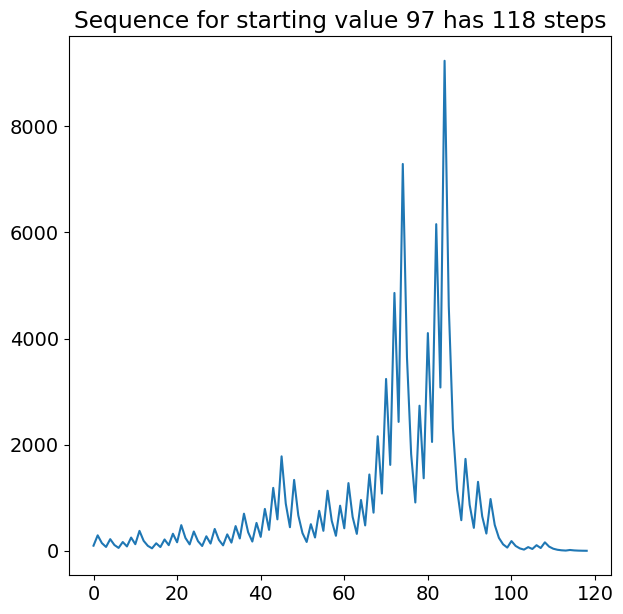

In [78]:
plt.plot(seq)
plt.title("Sequence for starting value %i has %i steps" % (start,len(seq)-1));

## The **Collatz Conjecture** is that this sequence will eventually reach the number $1$, regardless of which postive integer is chosen intitially.


### *Definition:* Given a positive integer $n \geq 1$, the *smallest* $k$ such that $a_k = 1$ is called the **total stopping time**.  

### If such a $k$ does not exist, we say that the total stopping time is infinite.

## The **Collatz conjecture** asserts that the total stopping time of every $n \geq 1$ is finite.

### Here is a list of the total stopping times for $n$ in $1, \ldots, 20$.

$$0, 1, 7, 2, 5, 8, 16, 3, 19, 6, 14, 9, 9, 17, 17, 4, 12, 20, 20, 7$$

### We can use Python to graph the total stopping times for $n$ in $1, \ldots, 100000$.

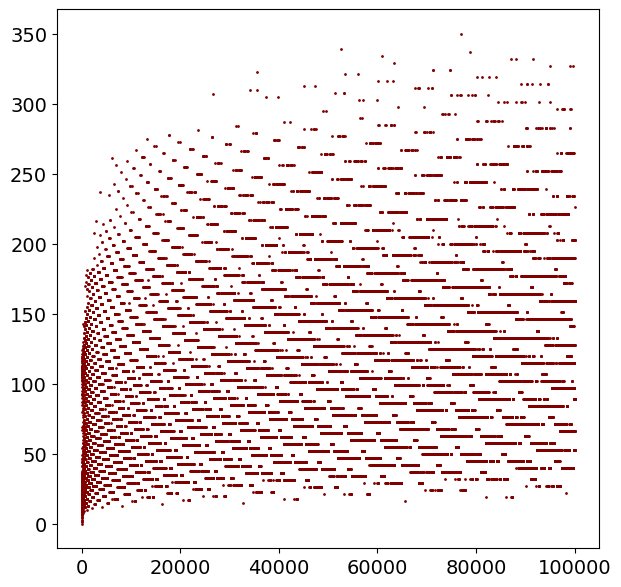

In [79]:
len_seq = []
for i in range(100000):
    seq = sequence(i+1)
    len_seq.append(len(seq)-1)
plt.scatter(range(1,100001),len_seq,s=1,color='maroon');

### As of 2020, the conjecture has been checked by computer for all values up to $2^{68} \approx 2.95 \times 10^{20}$.

### This computer evidence is not sufficient to prove the conjecture is true for all starting values since counterexamples still may be found when considering very large numbers!

### The following table of largest total stopping times was taken from the Wikipedia site for the Collatz conjecture.

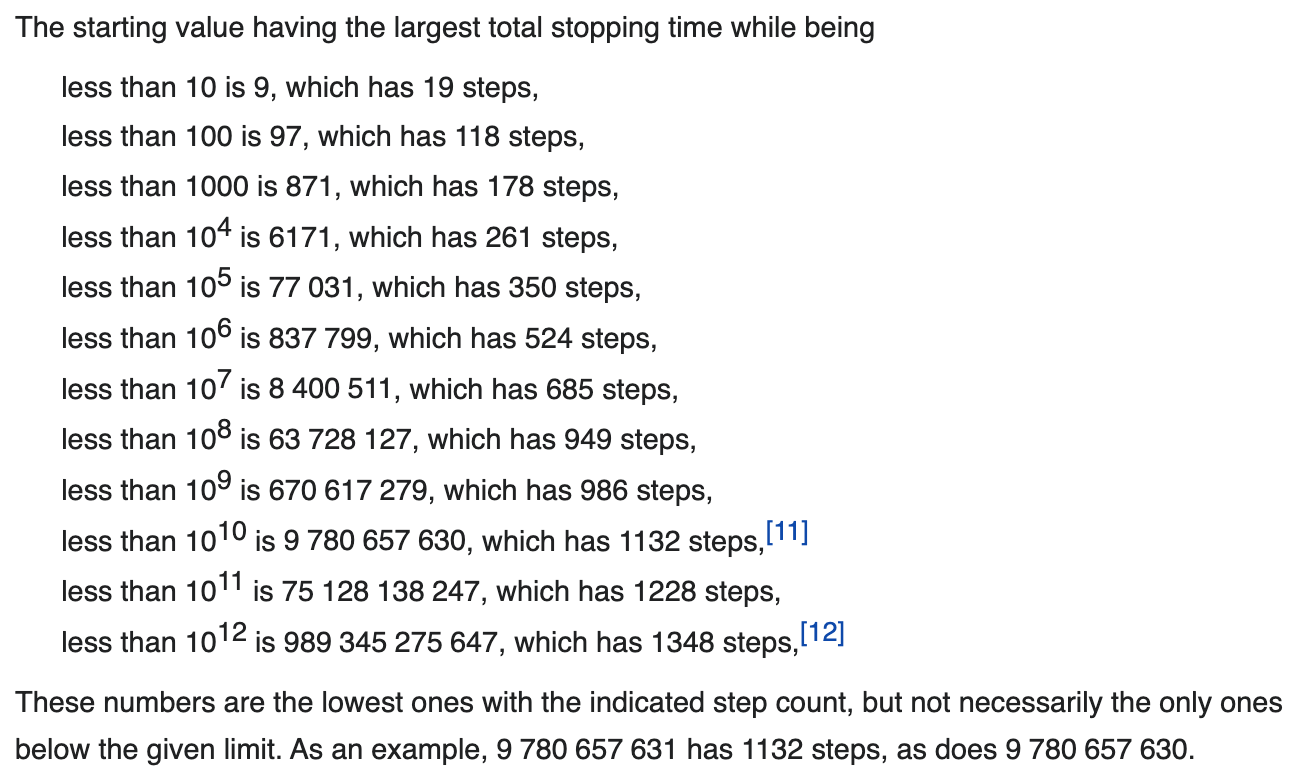

# Part 5 : Calculating Largest Total Stopping Times (Sequential in Python and C)

In [80]:
N = 100000
seq = []
len_seq = []
start = time.process_time()
for i in range(N):
    seq = sequence(i+1)
    len_seq.append(len(seq)-1)
max_start = np.argmax(len_seq)+1
max_total = np.max(len_seq)
elapsed = time.process_time()-start
print ("start <= %i with largest total is %i which has %i steps"%(N,max_start,max_total))
print ('elapsed time =',np.round(elapsed,2),'seconds')

start <= 100000 with largest total is 77031 which has 350 steps
elapsed time = 3.51 seconds


## With Python we can easily handle $N$ values up to around one hundred thousand.

## We can handle larger values of $N$ using a C program instead.

In [81]:
%%writefile collatz.c
#include <stdio.h>
#include <stdlib.h>

// compute the total stopping time of a given start value
int total_stopping_time (long long start) {
    int total = 0;
    long long a_i = start;
    while (a_i != 1) {
        total += 1;
        if (a_i % 2 == 0) {
            a_i /= 2;
        } else {
            a_i = 3*a_i + 1;
        }
    }
    return total;
}

int main (int argc, char** argv) {

    // get N from the command line
    if (argc < 2) {
        printf ("Command usage : %s %s\n",argv[0],"N");
        return 1;
    }
    long long N = atoll(argv[1]);

    // compute the start less than or equal to N with largest total stop
    int max_total = 0;
    long long max_start;
    for (long long start=1; start <= N; start++) {
        int total = total_stopping_time (start);
        if (total > max_total) {
	        max_total = total;
	        max_start = start;
        }
    }

    // output the results
    printf ("The starting value less than or equal to %lld\n",N);
    printf ("  having the largest total stopping time is %lld\n",max_start);
    printf ("  which has %d steps\n",max_total);
}

Writing collatz.c


## Compile with optimization flags.

In [91]:
!gcc -O3 -o collatz collatz.c

In [92]:
!time ./collatz 10000000

The starting value less than or equal to 10000000
  having the largest total stopping time is 8400511
  which has 685 steps

real	0m3.589s
user	0m3.578s
sys	0m0.002s


## Here is version 1 of an OpenMP version of the Collatz Program.

In [93]:
%%writefile omp_collatz_v1.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

// compute the total stopping time of a given start value
int total_stopping_time (long long start) {
    int total = 0;
    long long a_i = start;
    while (a_i != 1) {
        total += 1;
        if (a_i % 2 == 0) {
            a_i /= 2;
        } else {
            a_i = 3*a_i + 1;
        }
    }
    return total;
}

int main (int argc, char** argv) {

    // get N and num_threads from the command line
    if (argc < 3) {
        printf ("Command usage : %s N num_threads\n",argv[0]);
        return 1;
    }
    long long N = atoll(argv[1]);
    int num_threads = atoi(argv[2]);
    omp_set_num_threads(num_threads);

    // start the timer
    double start_time, end_time;
    start_time = omp_get_wtime();

    // compute the start less than or equal to N with largest total stop
    int max_total = 0;
    long long max_start;
    for (long long start=1; start <= N; start++) {
	    int total = total_stopping_time (start);
	    if (total > max_total) {
	        max_total = total;
	        max_start = start;
	    }
    }

    // stop the timer
    end_time = omp_get_wtime();

    // output the results
    printf ("num_threads = %d, ",num_threads);
    printf ("elapsed time = %.4f seconds\n",end_time-start_time);
    printf ("The starting value less than or equal to %lld\n",N);
    printf ("  having the largest total stopping time is %lld\n",max_start);
    printf ("  which has %d steps\n",max_total);
}

Writing omp_collatz_v1.c


# Part 6 : OpenMP Exercise

## Add OpenMP code to parallelize the loop in lines 39-45.

## Be sure that your code is **thread-safe** and **efficient**!

## After you have developed the code, compile it with **-O3** optimization flags and test it on matrix with $N=1000000$ to ensure that it is working with multiple threads and achieves good speedup!

## As a demo, run your finished code on matrix with **32 threads** to determine the maximum total stopping time for all starting values less than or equal to 200 million.

## What start value below 200 million has the largest total stopping time?

## Answer:

## What is the total stopping time for this start value?

## Answer:

## How long (in seconds) did it take your OpenMP code to run with 32 threads?  

## Answer: